# Self-Contained Source Separation

## Setup

First let's import libraries and create some convenience functions for our neural network operations with sane default values.

Unfortunately there isn't an easy way to hide code blocks in jupyter, so just skip over this :)

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import librosa

plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['image.cmap'] = 'hot'


def concat(x, y):
    return tf.concat([x, y], axis=3)


def conv(inputs, filters, kernel_size, stride):
    out = tf.layers.conv2d(
        inputs, filters=filters, kernel_size=kernel_size,
        kernel_initializer=tf.random_normal_initializer(stddev=0.02),
        strides=stride, padding='SAME')

    return out


def deconv(inputs, filters, kernel_size, stride):
    out = tf.layers.conv2d_transpose(
        inputs, filters=filters, kernel_size=kernel_size,
        kernel_initializer=tf.random_normal_initializer(stddev=0.02),
        strides=stride, padding='SAME')

    return out


def batch_norm(inputs, is_training, reuse):
    return tf.contrib.layers.batch_norm(
        inputs,
        decay=0.9,
        updates_collections=None,
        epsilon=1e-5,
        scale=True,
        is_training=is_training,
        reuse=reuse)


def dropout(inputs, rate):
    return tf.nn.dropout(inputs, keep_prob=1 - rate)


def relu(inputs):
    return tf.nn.relu(inputs)


def tanh(inputs):
    return tf.nn.tanh(inputs)


def lrelu(x, leak=0.2):
    with tf.variable_scope('lrelu'):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)


def l1_loss(x, y):
    return tf.reduce_mean(tf.abs(x - y))


def read_audio(path, sample_rate, n_channels):

    def read_audio_py(py_path):
        #if n_channels == 1:
            mono, _ = librosa.load(py_path, sr=sample_rate, mono=True)
            return np.expand_dims(mono, 1)
        #elif n_channels == 2:
            #stereo, _ = librosa.load(py_path, sr=sample_rate, mono=False)
            #return stereo.T
        #else:
            #raise ValueError('Invalid channels: %d' % n_channels)

    return tf.py_func(read_audio_py, [path], tf.float32, stateful=False)


def fake_stereo(audio):

    def fake_stereo(x):
        return tf.stack([x, x], 1)
    
    voice = audio[:, 0]
    noise = audio[:, 0]   #was noise = audio[:, 1]
    mixed = voice + noise
    return fake_stereo(mixed), fake_stereo(voice), fake_stereo(noise)


def compute_spectrogram(audio, n_fft, fft_hop, n_channels):
    '''
    Parameters
    ----------
    audio : single to dual channel audio shaped (n_samples, n_channels)

    Returns
    -------
    Tensor of shape (n_frames, 1 + n_fft / 2, n_channels * 2), where the
        last dimension is (left_mag, right_mag, left_phase, right_phase)
    '''

    def stft(x):
        spec = librosa.stft(
            x, n_fft=n_fft, hop_length=fft_hop, window='hann')
        # TODO: normalize?
        return np.abs(spec), np.angle(spec)

    #def stereo_func(py_audio):
    #    left_mag, left_phase = stft(py_audio[:, 0])
    #    right_mag, right_phase = stft(py_audio[:, 1])
    #    ret = np.array([left_mag, right_mag, left_phase, right_phase]).T
    #    return ret.astype(np.float32)

    def mono_func(py_audio):
        mag, phase = stft(py_audio[:, 0])
        ret = np.array([mag, phase]).T
        return ret.astype(np.float32)

    #if n_channels == 2:
    #    func = stereo_func
    #elif n_channels == 1:
    #    func = mono_func
    #else:
    #    raise ValueError('Invalid channels: %d' % n_channels)

    with tf.name_scope('read_spectrogram'):
        ret = tf.py_func(mono_func, [audio], tf.float32, stateful=False)
        ret.set_shape([None, 1 + n_fft / 2, 2])   # n_channels * 2])
    return ret


def extract_spectrogram_patches(
        spec, n_fft, n_channels, patch_window, patch_hop):
    '''
    Parameters
    ----------
    spec : Spectrogram of shape (n_frames, 1 + n_fft / 2, n_channels * 2)

    Returns
    -------
    Tensor of shape (n_patches, patch_window, 1 + n_fft / 2, n_channels * 2)
        containing patches from spec.
    '''
    with tf.name_scope('extract_spectrogram_patches'):
        spec4d = tf.expand_dims(spec, 0)

        patches = tf.extract_image_patches(
            spec4d, ksizes=[1, patch_window, 1 + n_fft / 2, 1],
            strides=[1, patch_hop, 1 + n_fft / 2, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )

        num_patches = tf.shape(patches)[1]

        return tf.reshape(patches, [num_patches, patch_window,
                                    int(1 + n_fft / 2), 2])   # int(n_channels * 2)]) #here was '1 + n_fft / 2, n_channels * 2', 
                                                                              #it was causing an error in 6th code block


def hwr_tf(x):
    return x * tf.cast(x > 0.0, tf.float32)


def compute_acapella_diff(mixed, noise):
    mixed_mag = mixed[:, :, 0:, :2]
    mixed_phase = mixed[:, :, 0:, 2:]
    noise_mag = noise[:, :, 0:, :2]
    voice_mag = hwr_tf(mixed_mag - noise_mag) # TODO: normalize?
    voice_phase = mixed_phase
    return mixed, noise, tf.concat((voice_mag, voice_phase), axis=3)


def partial_argv(func, *args, **kwargs):
    '''
    Parameters
    ----------
    func    : A function that takes scalar argument and returns scalar value
    *args   : Args to partially apply to func
    *kwargs : Keyword args to partially apply to func

    Returns
    -------
    func(*args) : A function that maps func over *args and returns a tuple

    Example
    -------
    func = partial_argv(abs)
    func(-1, 2, -3, 4)

    # returns (1, 2, 3, 4)
    '''
    return lambda *other_args: tuple(map(partial(func, *args, **kwargs), other_args))


def zip_tensor_slices(*args):
    '''
    Parameters
    ----------
    *args : list of _n_ _k_-dimensional tensors, where _k_ >= 2
        The first dimension has _m_ elements.

    Returns
    -------
    result : Dataset of _m_ examples, where each example has _n_
        records of _k_ - 1 dimensions.

    Example
    -------
    ds = (
        tf.data.Dataset.zip((
            tf.data.Dataset.from_tensors([[1,2], [3,4], [5, 6]]),
            tf.data.Dataset.from_tensors([[10, 20], [30, 40], [50, 60]])
        ))
        .flat_map(zip_tensor_slices)  # <--- *HERE*
    )
    el = ds.make_one_shot_iterator().get_next()
    print sess.run(el)
    print sess.run(el)

    # Output:
    # (array([1, 2], dtype=int32), array([10, 20], dtype=int32))
    # (array([3, 4], dtype=int32), array([30, 40], dtype=int32))
    '''
    return tf.data.Dataset.zip(tuple([
        tf.data.Dataset.from_tensor_slices(arg)
        for arg in args
    ]))

C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Let's define a few constants we'll use throughout.

In [2]:
SAMPLE_RATE = 44100
N_FFT = 1024
FFT_HOP = 256
N_CHANNELS = 1   #was N_CHANNELS = 2
N_PARALLEL_READERS = 4
PATCH_WINDOW = 256
PATCH_HOP = 128
BATCH_SIZE = 8
N_SHUFFLE = 20

## U-Net Model

Next, we create our U-Nets, one for noise and one for voice. Each `UNetModel` has a `UNetEncoder` and a `UNetDecoder`.

In [3]:
class UNetModel(object):

    def __init__(self, mixed, noise, voice, mixed_phase, is_training):
        self.mixed = mixed
        self.noise = noise
        self.voice = voice
        self.mixed_phase = mixed_phase
        self.is_training = is_training

        self.noise_mask_unet = UNet(mixed, is_training=is_training, reuse=False, name='noise-mask-unet')
        self.voice_mask_unet = UNet(mixed, is_training=is_training, reuse=False, name='voice-mask-unet')

        self.noise_mask = self.noise_mask_unet.output
        self.voice_mask = self.voice_mask_unet.output

        self.gen_noise = self.noise_mask * mixed
        self.gen_voice = self.voice_mask * mixed

        self.noise_reconstr_cost = l1_loss(self.gen_noise, noise)
        self.voice_reconstr_cost = l1_loss(self.gen_voice, voice)
        self.cost = self.noise_reconstr_cost + self.voice_reconstr_cost

        self.optimizer = tf.train.AdamOptimizer(
            learning_rate=0.0002,
            beta1=0.5,
        )
        self.train_op = self.optimizer.minimize(self.cost)


class UNet(object):

    def __init__(self, input_tensor, is_training, reuse, name):
        with tf.variable_scope(name, reuse=reuse):

            self.encoder = UNetEncoder(input_tensor, is_training, reuse)
            self.decoder = UNetDecoder(self.encoder.output, self.encoder, is_training, reuse)

            self.output = tanh(self.decoder.output) / 2 + .5


class UNetEncoder(object):

    def __init__(self, input_tensor, is_training, reuse):
        net = input_tensor
        with tf.variable_scope('encoder'):
            with tf.variable_scope('layer-1'):
                net = conv(net, filters=16, kernel_size=5, stride=(2, 2))
                self.l1 = net

            with tf.variable_scope('layer-2'):
                net = lrelu(net)
                net = conv(net, filters=32, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)
                self.l2 = net

            with tf.variable_scope('layer-3'):
                net = lrelu(net)
                net = conv(net, filters=64, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)
                self.l3 = net

            with tf.variable_scope('layer-4'):
                net = lrelu(net)
                net = conv(net, filters=128, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)
                self.l4 = net

            with tf.variable_scope('layer-5'):
                net = lrelu(net)
                net = conv(net, filters=256, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)
                self.l5 = net

            with tf.variable_scope('layer-6'):
                net = lrelu(net)
                net = conv(net, filters=512, kernel_size=5, stride=(2, 2))

            self.output = net


class UNetDecoder(object):

    def __init__(self, input_tensor, encoder, is_training, reuse):
        net = input_tensor

        with tf.variable_scope('decoder'):
            with tf.variable_scope('layer-1'):
                net = relu(net)
                net = deconv(net, filters=256, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)
                net = dropout(net, .5)

            with tf.variable_scope('layer-2'):
                net = relu(concat(net, encoder.l5))
                net = deconv(net, filters=128, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)
                net = dropout(net, .5)

            with tf.variable_scope('layer-3'):
                net = relu(concat(net, encoder.l4))
                net = deconv(net, filters=64, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)
                net = dropout(net, .5)

            with tf.variable_scope('layer-4'):
                net = relu(concat(net, encoder.l3))
                net = deconv(net, filters=32, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)


            with tf.variable_scope('layer-5'):
                net = relu(concat(net, encoder.l2))
                net = deconv(net, filters=16, kernel_size=5, stride=(2, 2))
                net = batch_norm(net, is_training=is_training, reuse=reuse)

            with tf.variable_scope('layer-6'):
                net = relu(concat(net, encoder.l1))
                net = deconv(net, filters=1, kernel_size=5, stride=(2, 2))

            self.output = net


## Data Pipelines

Next we define our data reading functions. We make use of [the Dataset API](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [4]:
def training_dataset(
        data_folder,
        sample_rate,
        n_fft,
        fft_hop,
        n_channels,
        patch_window,
        patch_hop,
        batch_size,
        n_shuffle,
        n_parallel_readers
):
    return (
        tf.data.Dataset.list_files(data_folder + '/*.wav')
        .map(partial(
            read_audio,
            sample_rate=sample_rate,
            n_channels=n_channels
        ), num_parallel_calls=n_parallel_readers)
        .map(fake_stereo, num_parallel_calls=n_parallel_readers)
        .map(partial_argv(
            compute_spectrogram,
            n_fft=n_fft,
            fft_hop=fft_hop,
            n_channels=n_channels,
        ), num_parallel_calls=n_parallel_readers)
        .map(partial_argv(
            extract_spectrogram_patches,
            n_fft=n_fft,
            n_channels=n_channels,
            patch_window=patch_window,
            patch_hop=patch_hop,
        ))
        .flat_map(zip_tensor_slices)
        .batch(batch_size)
        .shuffle(n_shuffle)
        .repeat()
    )

Next let's create the Tensorflow [Session](https://www.tensorflow.org/programmers_guide/graphs).

In [5]:
tf.reset_default_graph()
sess = tf.Session()

We can look at some examples from the training set:

In [6]:
ds = training_dataset('C:/Users/Toby/Jupyter Notebooks/My Work/MSc Project/CHiME3/data/audio/16kHz/isolated/et05_bus_simu', SAMPLE_RATE, N_FFT, FFT_HOP, N_CHANNELS, PATCH_WINDOW, PATCH_HOP, BATCH_SIZE, N_SHUFFLE, N_PARALLEL_READERS)
mixed, noise, voice = ds.make_one_shot_iterator().get_next()
m, n, v = sess.run([mixed, noise, voice])

Here `mixed`, `noise`, and `voise` are [tensors](https://www.tensorflow.org/programmers_guide/tensors), whereas `m`, `n`, and `v` are regular python variables containing the training examples.

`m`, `n`, and `v` are all the same shape: (batch\_size, patch\_window, n\_fft + 1, 4)

where the last dimension is composed of [left mag, right mag, left phase, right phase].

In [9]:
ds

<RepeatDataset shapes: ((?, 256, 513, 2), (?, 256, 513, 2), (?, 256, 513, 2)), types: (tf.float32, tf.float32, tf.float32)>

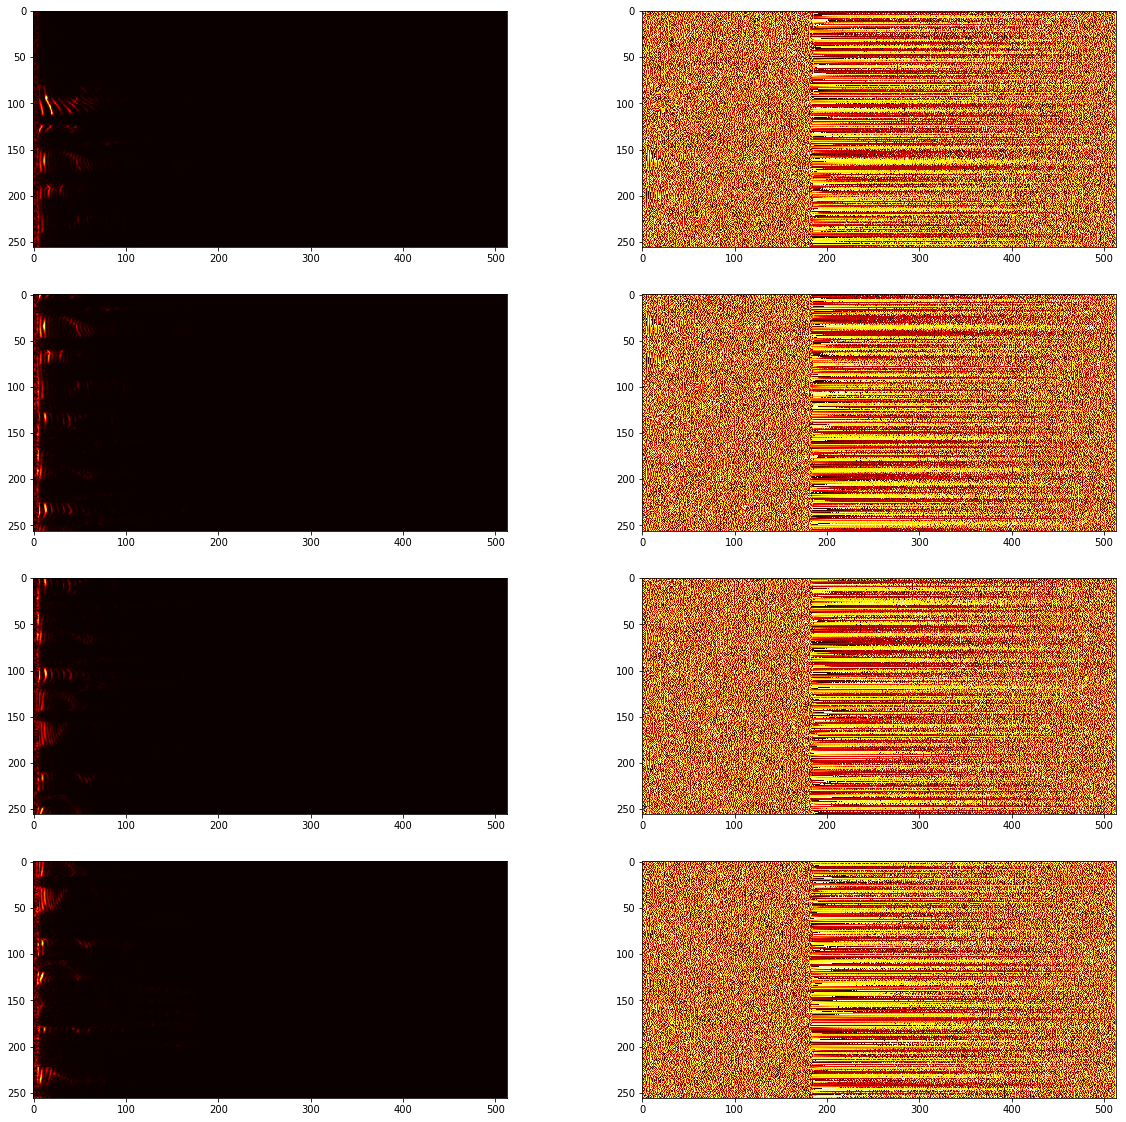

In [8]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(20,20))
ax1.imshow(m[0, :, :, 0])
ax2.imshow(m[0, :, :, 1])
ax3.imshow(m[1, :, :, 0])
ax4.imshow(m[1, :, :, 1])
ax5.imshow(m[2, :, :, 0])
ax6.imshow(m[2, :, :, 1])
ax7.imshow(m[3, :, :, 0])
ax8.imshow(m[3, :, :, 1])

## Training

Now that we have both the model and the data pipeline we can actually train a model.

In [9]:
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = mixed[:, :, 1:, :2]
mixed_phase = mixed[:, :, 1:, 2:]
noise_mag = noise[:, :, 1:, :2]
voice_mag = voice[:, :, 1:, :2]

model = UNetModel(
    mixed_mag,
    noise_mag,
    voice_mag,
    mixed_phase,
    is_training
)

sess.run(tf.global_variables_initializer())

Predictions before training on a random batch from the training set:

In [10]:
single_mixed_batch, single_noise_batch = sess.run([mixed_mag, noise_mag])

Text(0.5,1,'generated noise  before training')

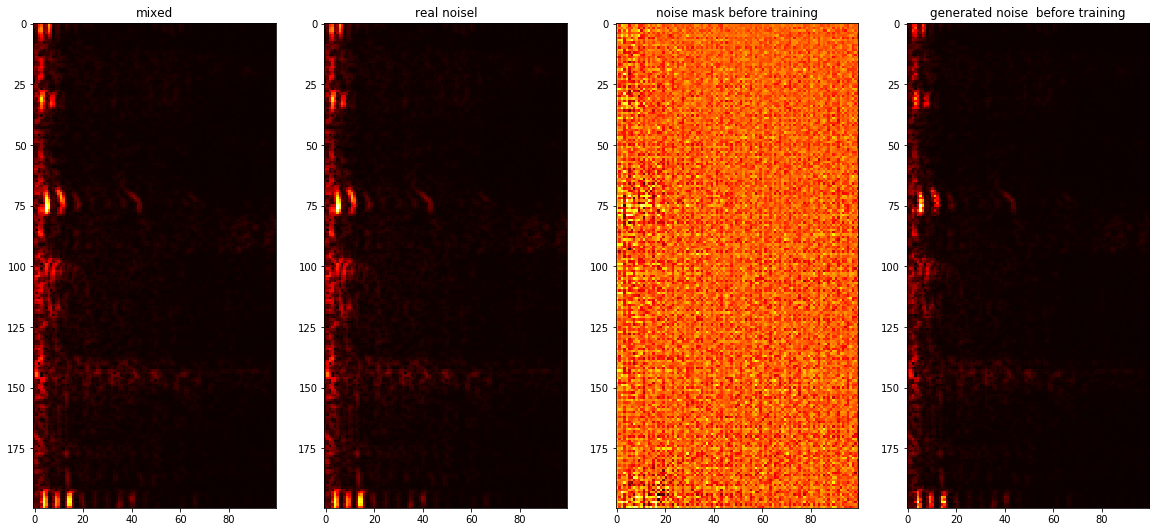

In [11]:
gen_noise, noise_mask = sess.run([model.gen_noise, model.noise_mask], {is_training: True, model.mixed: single_mixed_batch})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,20))

ax1.imshow(single_mixed_batch[0, :200, :100, 0])
ax1.set_title('mixed')
ax2.imshow(single_noise_batch[0, :200, :100, 0])
ax2.set_title('real noisel')
ax3.imshow(noise_mask[0, :200, :100, 0])
ax3.set_title('noise mask before training')
ax4.imshow(gen_noise[0, :200, :100, 0])
ax4.set_title('generated noise  before training')

Now let's train a small number of iterations.

In [12]:
for i in range(10):
    _, cost = sess.run([model.train_op, model.cost], {model.is_training: True})
    print("            , {0}, {1}".format(i, cost)) #here we had code 'print "            ", i, cost', it was causing an error
                                                    #most likely related to python syntax changes in newer version

            , 0, 0.8148696422576904
            , 1, 0.8426012396812439
            , 2, 0.8225305676460266
            , 3, 0.8231755495071411
            , 4, 0.8257222771644592
            , 5, 0.7967308163642883
            , 6, 0.7807074785232544
            , 7, 0.7695503234863281
            , 8, 0.7624030709266663
            , 9, 0.750045895576477


Text(0.5,1,'generated noise after 10 train iterations')

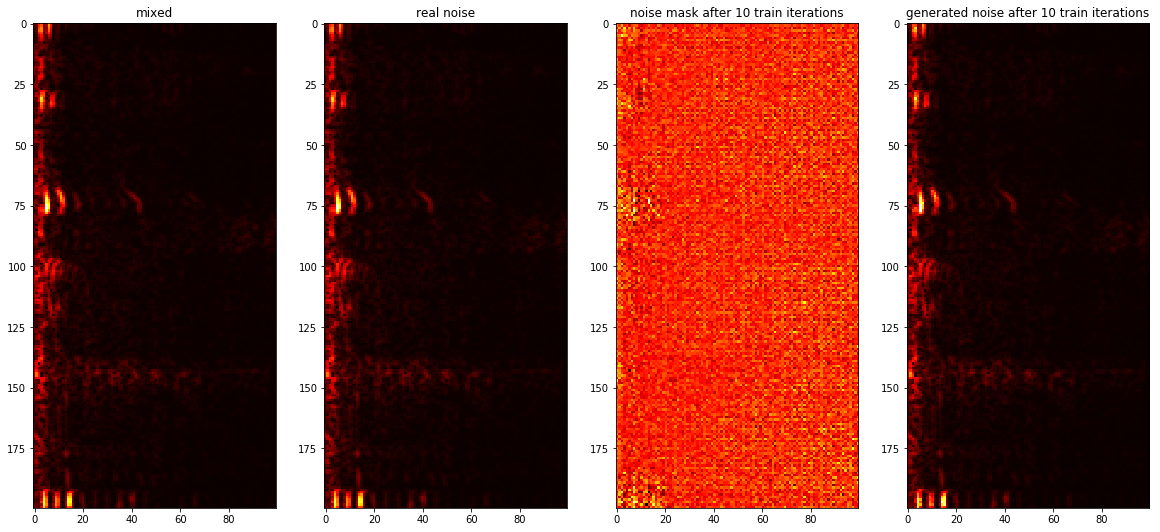

In [13]:
gen_noise, noise_mask = sess.run([model.gen_noise, model.noise_mask], {is_training: True, model.mixed: single_mixed_batch})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,20))

ax1.imshow(single_mixed_batch[0, :200, :100, 0])
ax1.set_title('mixed')
ax2.imshow(single_noise_batch[0, :200, :100, 0])
ax2.set_title('real noise')
ax3.imshow(noise_mask[0, :200, :100, 0])
ax3.set_title('noise mask after 10 train iterations')
ax4.imshow(gen_noise[0, :200, :100, 0])
ax4.set_title('generated noise after 10 train iterations')

Let's train a little longer this time.

In [14]:
for i in range(20):
    _, cost = sess.run([model.train_op, model.cost], {model.is_training: True})
    print("            , {0}, {1}".format(i, cost)) #same code from above 'print "            ", i, cost', was causing an error

            , 0, 0.7278575897216797
            , 1, 0.7254916429519653
            , 2, 0.7416315078735352
            , 3, 0.7051385641098022
            , 4, 0.6998957395553589
            , 5, 0.6971437335014343
            , 6, 0.689937174320221
            , 7, 0.6678715944290161
            , 8, 0.664761483669281
            , 9, 0.6641116142272949
            , 10, 0.658167839050293
            , 11, 0.640519380569458
            , 12, 0.640680730342865
            , 13, 0.6284613609313965
            , 14, 0.6139890551567078
            , 15, 0.6241467595100403
            , 16, 0.6073468923568726
            , 17, 0.589816689491272
            , 18, 0.6031515598297119
            , 19, 0.578413724899292


Text(0.5,1,'generated noise after 30 train iterations')

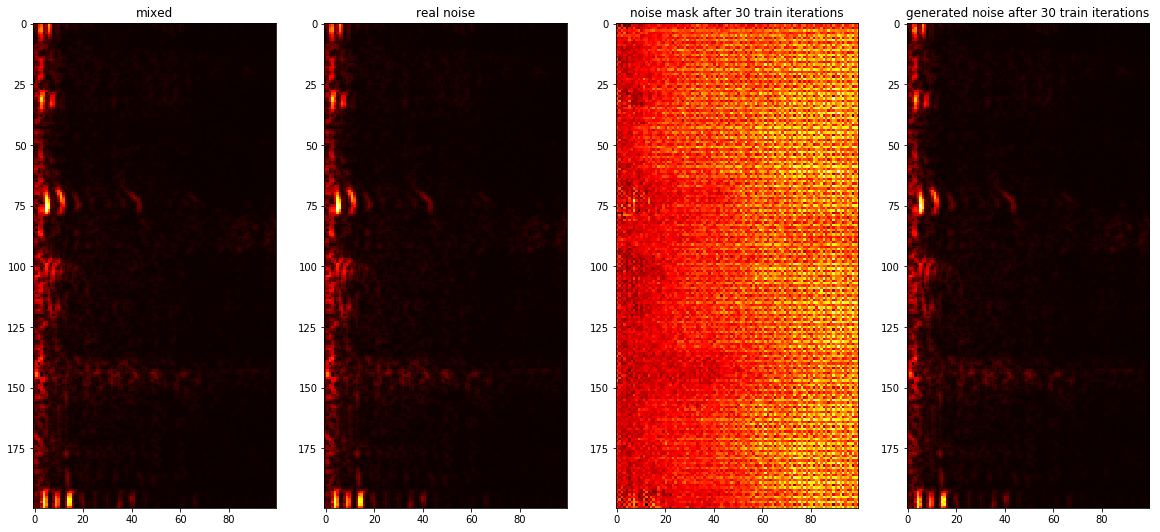

In [15]:
gen_noise, noise_mask = sess.run([model.gen_noise, model.noise_mask], {is_training: False, model.mixed: single_mixed_batch})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,20))

ax1.imshow(single_mixed_batch[0, :200, :100, 0])
ax1.set_title('mixed')
ax2.imshow(single_noise_batch[0, :200, :100, 0])
ax2.set_title('real noise')
ax3.imshow(noise_mask[0, :200, :100, 0])
ax3.set_title('noise mask after 30 train iterations')
ax4.imshow(gen_noise[0, :200, :100, 0])
ax4.set_title('generated noise after 30 train iterations')

Text(0.5,1,'generated voice after 30 train iterations')

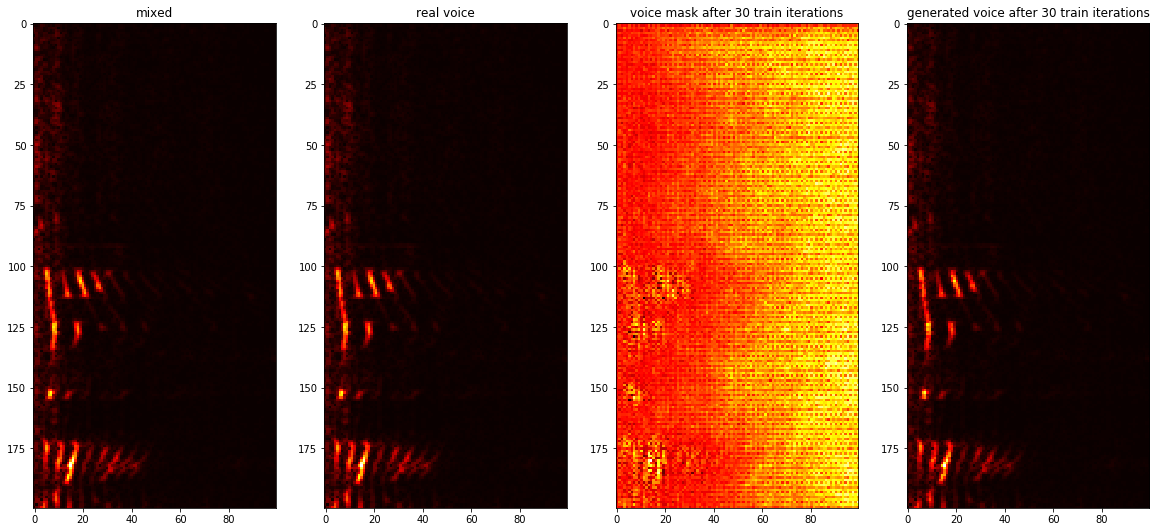

In [16]:
single_mixed_batch, single_voice_batch = sess.run([mixed_mag, voice_mag])
gen_voice, voice_mask = sess.run([model.gen_voice, model.voice_mask], {is_training: False, model.mixed: single_mixed_batch})
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,20))

ax1.imshow(single_mixed_batch[0, :200, :100, 0])
ax1.set_title('mixed')
ax2.imshow(single_voice_batch[0, :200, :100, 0])
ax2.set_title('real voice')
ax3.imshow(voice_mask[0, :200, :100, 0])
ax3.set_title('voice mask after 30 train iterations')
ax4.imshow(gen_voice[0, :200, :100, 0])
ax4.set_title('generated voice after 30 train iterations')